In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import callbacks 

import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.pruners import HyperbandPruner

from keras import callbacks 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import backend as K

from sklearn.preprocessing import MinMaxScaler

import joblib

**Read data**

In [95]:
#read into DataFrame
df_train = pd.read_csv('input/train.csv')
df_test= pd.read_csv('input/test.csv')

In [96]:
#enable to see all columns in a notebook
pd.set_option('display.max_columns', None)

#enable to see all rows in a notebook
pd.set_option('display.max_rows', None)

In [97]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [98]:
df_train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [99]:
# Check NaN

train_nan=df_train.isnull().sum().sort_values(ascending = False)[0:20]
test_nan=df_test.isnull().sum().sort_values(ascending = False)[0:20]




x = pd.DataFrame(train_nan, columns=['train'])
x['test']=test_nan

# Using Dataframe.apply() and lambda function
x["train [%]"] = x["train"].apply(lambda x: round((x/df_train.shape[0])*100))

print(x)

print("Number of rows-train:", df_train.shape[0])
print("Number of rows-test:", df_test.shape[0])

             train   test  train [%]
Cabin          687  327.0         77
Age            177   86.0         20
Embarked         2    0.0          0
PassengerId      0    0.0          0
Survived         0    NaN          0
Pclass           0    0.0          0
Name             0    0.0          0
Sex              0    0.0          0
SibSp            0    0.0          0
Parch            0    0.0          0
Ticket           0    0.0          0
Fare             0    1.0          0
Number of rows-train: 891
Number of rows-test: 418


In [100]:
#dropping columns with certain percentage of NaN
perc = 75 #percentage of NaN


min_count =  int(((100-perc)/100)*df_train.shape[0] + 1)
df_train = df_train.dropna( axis=1, thresh=min_count)


min_count =  int(((100-perc)/100)*df_test.shape[0] + 1)
df_test = df_test.dropna( axis=1, thresh=min_count)


In [101]:
# Check NaN

train_nan=df_train.isnull().sum().sort_values(ascending = False)[0:20]
test_nan=df_test.isnull().sum().sort_values(ascending = False)[0:20]

x = pd.DataFrame(train_nan, columns=['train'])
x['test']=test_nan

# Using Dataframe.apply() and lambda function
x["train [%]"] = x["train"].apply(lambda x: round((x/df_train.shape[0])*100))

print(x)

print("Number of rows-train:", df_train.shape[0])
print("Number of rows-test:", df_test.shape[0])

             train  test  train [%]
Age            177  86.0         20
Embarked         2   0.0          0
PassengerId      0   0.0          0
Survived         0   NaN          0
Pclass           0   0.0          0
Name             0   0.0          0
Sex              0   0.0          0
SibSp            0   0.0          0
Parch            0   0.0          0
Ticket           0   0.0          0
Fare             0   1.0          0
Number of rows-train: 891
Number of rows-test: 418


**Fill in the NaN**

In [102]:
#function that selects nonstring only colums without string and fill in NaN colums with mean value

def fillin_mean(data_frame):

    #selecting all columns without String
    string_check=data_frame.select_dtypes(exclude=['object'])

    #checking if columns without string have NaN
    nan_check=string_check.isnull().sum().sort_values(ascending = False)[0:20]

    #converting Index an Value in the list
    list_index=nan_check.index.values.tolist()
    list_value=nan_check.values.tolist()

    #creating array from 2 lists
    new_array=np.column_stack((list_index,list_value))

    #creating unique list by expecting the array
    unique_list=[]
    for x in range(len(new_array)):
        if new_array[x,1] != '0':
            unique_list.append(new_array[x,0])

    #fill in the N/A with the mean
    if unique_list !=[]:
        data_frame[unique_list]=data_frame[unique_list].fillna(data_frame[unique_list].median()) #mean()
        data_frame.head()
        print("In following columns were NaN changed to mean: ",unique_list)
    else:
        print("All columns without string DON'T contain NaN.")

#call the function
fillin_mean(df_train)
fillin_mean(df_test)


In following columns were NaN changed to mean:  ['Age']
In following columns were NaN changed to mean:  ['Age', 'Fare']


In [103]:
# Check NaN - final check

train_nan=df_train.isnull().sum().sort_values(ascending = False)[0:20]
test_nan=df_test.isnull().sum().sort_values(ascending = False)[0:20]

#Creating DataFrame x
x = pd.DataFrame(train_nan, columns=['train'])
x['test']=test_nan #adding column to dataframe

# Using Dataframe.apply() and lambda function
x["train [%]"] = x["train"].apply(lambda x: round((x/df_train.shape[0])*100))

print(x)

print("Number of rows-train:", df_train.shape[0])
print("Number of rows-test:", df_test.shape[0])


             train  test  train [%]
Embarked         2   0.0          0
PassengerId      0   0.0          0
Survived         0   NaN          0
Pclass           0   0.0          0
Name             0   0.0          0
Sex              0   0.0          0
Age              0   0.0          0
SibSp            0   0.0          0
Parch            0   0.0          0
Ticket           0   0.0          0
Fare             0   0.0          0
Number of rows-train: 891
Number of rows-test: 418


**Categorical values**

In [104]:
#categorical values
categ_columns = df_train.select_dtypes(exclude=[np.number])
categ_columns.describe()

,Name,Sex,Ticket,Embarked
count,891,891,891,889
unique,891,2,681,3
top,"Braund, Mr. Owen Harris",male,347082,S
freq,1,577,7,644


In [105]:
#get a closer look at categorical
df_train['Sex'].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

**Bins**

In [106]:
#bin - AGE

df_train['Age_bin'] = pd.cut(df_train['Age'], bins=[0,12,20,40,120], labels=['Children','Teenage','Adult','Elder'])
df_test['Age_bin'] = pd.cut(df_test['Age'], bins=[0,12,20,40,120], labels=['Children','Teenage','Adult','Elder'])

In [107]:
#bin - FARE

#get a list
def split_data(data_frame, column_name):
    #load: min, 25%, 50%=mean, 75%=median, max
    stat=data_frame[column_name].describe()

    #import data into list
    stat_list=stat.values.tolist()

    #slice first 3
    stat_list=stat_list[3:]
    return stat_list

train_list=split_data(df_train,'Fare')
test_list=split_data(df_test,'Fare')

# import list into bin and create new columns
df_train['Fare_bin'] = pd.cut(df_train['Fare'], bins=train_list, labels=['0÷25%_fare','25÷50%_fare','50÷75%_fare','75÷100%_fare'])
df_test['Fare_bin'] = pd.cut(df_test['Fare'], bins=test_list, labels=['0÷25%_fare','25÷50%_fare','50÷75%_fare','75÷100%_fare'])


In [108]:
df_test.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_bin,Fare_bin
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,Adult,0÷25%_fare


**Dummies**

In [109]:
#change categorical-dummies
df_train = pd.get_dummies(df_train, columns = ["Sex","Embarked",'Age_bin','Fare_bin'], prefix=["gender","Em",'Age_type', 'Ticket'])
df_test = pd.get_dummies(df_test, columns = ["Sex","Embarked",'Age_bin','Fare_bin'], prefix=["gender","Em",'Age_type', 'Ticket'])

In [110]:
df_train.head(1)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,gender_female,gender_male,Em_C,Em_Q,Em_S,Age_type_Children,Age_type_Teenage,Age_type_Adult,Age_type_Elder,Ticket_0÷25%_fare,Ticket_25÷50%_fare,Ticket_50÷75%_fare,Ticket_75÷100%_fare
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.25,False,True,False,False,True,False,False,True,False,True,False,False,False


In [111]:
#FINAL replacing string by NaN
for col in df_train.columns:
    df_train[col] = pd.to_numeric(df_train[col], errors='coerce')

for col in df_test.columns:
    df_test[col] = pd.to_numeric(df_test[col], errors='coerce')
    
#fill in the NaN with the mean in all columns
df_train=df_train.fillna(df_train.mean())
df_test=df_test.fillna(df_test.mean())


#delete all columns containing NAN - in case of colums full of string become NaN-impossible to do a mean from string
df_train=df_train.dropna(axis=1, how='all')
df_test=df_test.dropna(axis=1, how='all')


In [112]:
#RUN STATS - HOW MANY NaN - Final check

train_nan=df_train.isnull().sum().sort_values(ascending = False)[0:20]
test_nan=df_test.isnull().sum().sort_values(ascending = False)[0:20]

x = pd.DataFrame(train_nan, columns=['train'])
x['test']=test_nan

#Using Dataframe.apply() and lambda function
x["train [%]"] = x["train"].apply(lambda x: round((x/df_train.shape[0])*100))

print(x)

print("Number of rows-train:", df_train.shape[0])
print("Number of rows-test:", df_test.shape[0])

                    train  test  train [%]
PassengerId             0   0.0          0
Em_Q                    0   0.0          0
Ticket_50÷75%_fare      0   0.0          0
Ticket_25÷50%_fare      0   0.0          0
Ticket_0÷25%_fare       0   0.0          0
Age_type_Elder          0   0.0          0
Age_type_Adult          0   0.0          0
Age_type_Teenage        0   0.0          0
Age_type_Children       0   0.0          0
Em_S                    0   0.0          0
Em_C                    0   0.0          0
Survived                0   NaN          0
gender_male             0   0.0          0
gender_female           0   0.0          0
Fare                    0   0.0          0
Ticket                  0   0.0          0
Parch                   0   0.0          0
SibSp                   0   0.0          0
Age                     0   0.0          0
Pclass                  0   0.0          0
Number of rows-train: 891
Number of rows-test: 418


# Split dataframe

In [113]:
#dropping ID and other columns
df_train=df_train.drop(['PassengerId', 'Ticket'], axis=1)

df_test=df_test.drop(['PassengerId','Ticket'], axis=1)

In [114]:
#defining input=X and output=y for models
input=df_train.drop(['Survived'], axis=1)
output=df_train[['Survived']]

#independant
X=input

#dependant
y=output

# Scaling data

In [115]:
#convert dataframe into numpy - due to cross valiadation
X_np=X.values
y_np=y.values

#for test data
X_test_np=df_test.values

In [116]:
#scale data

scaler=MinMaxScaler()
X_np_scaled=scaler.fit_transform(X_np)
y_np_scaled=scaler.fit_transform(y_np)

#for test data
X_test_np_scaled=scaler.fit_transform(X_test_np)

# Splitting data

In [117]:
#scale and split data
from sklearn.model_selection import train_test_split

scale=True

if scale==False:
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
     print('Data NOT scaled!')

elif scale==True:
    X_train, X_test, y_train, y_test = train_test_split(X_np_scaled, y_np_scaled, test_size=0.25, random_state=42)
    print('Data scaled!')

Data scaled!


# Neural Networks

In [118]:
#define NN function
def make_net(number_features=X.shape[1],# number of columns/features in training data
            hidden_layers=2,
            hidden_layer_neurons=40,
            dropout=0.0):

    #clear previous TensorFlow:
    K.clear_session()

    #define model
    mod=Sequential()

    #add input layer
    mod.add(Dense(hidden_layer_neurons, input_dim=number_features, activation='relu')) 

    #add hidden layers
    for i in range(hidden_layers):   
        mod.add(Dense(hidden_layer_neurons, activation='relu'))

        #add dropout layer
        mod.add(Dropout(dropout))

    #add final layer
    mod.add(Dense(1, activation='sigmoid')) #I have to chose 1, because it is binary classification

    # Compile model
    mod.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return mod



In [119]:
#define ploting function
def plot_training(history_dict):
    acc_values=history_dict['accuracy']
    val_acc_values=history_dict['val_accuracy']
    epochs=range(1,len(acc_values)+1)

    plt.plot(epochs,acc_values, label='Training accuracy',  c="blue")
    plt.plot(epochs,val_acc_values, label='Test accuracy', c="red")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [120]:
#define scoring function
def print_accuracy(m):
    pred_train= m.predict(X_train)
    score_train = m.evaluate(X_train, y_train, verbose=0)
    print(f'Accuracy on training data: {round(score_train[1]*100,2)} %')   

    #score on test data
    pred_test= m.predict(X_test)
    score_test = m.evaluate(X_test, y_test, verbose=0)
    print(f'Accuracy on test data: {round(score_test[1]*100,2)} %')    

    #diference(train-test)
    delta=(score_train[1]-score_test[1])
    print(f'Diference(train-test): {round(delta*100,2)} %')   


**Fit and run**

In [121]:
X.shape[1]

18

In [122]:
#define model
model = make_net(number_features=X.shape[1],# number of columns/features in training data
            hidden_layers=10,
            hidden_layer_neurons=200,
            dropout=0.0
            )

c:\Users\Martin\.virtualenvs\venv_portfolio-hkOMkeu3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [123]:

early_stopping=callbacks.EarlyStopping(patience=20)

#fit model
#store data from computing in history
hist=model.fit(X_train, y_train, 
                validation_data=(X_test, y_test),
                epochs=100, 
                batch_size = 64,
                callbacks=[early_stopping],
                verbose=0 # Set verbose to 0 to turn off output during training
                )

In [124]:
print_accuracy(model)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy on training data: 84.43 %
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy on test data: 73.54 %
Diference(train-test): 10.89 %


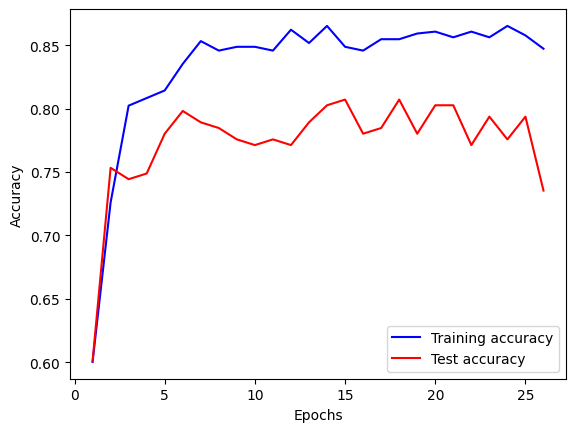

In [125]:
plot_training(hist.history)

# Optuna - optimizing

**OPTUNA-I-CREATE FUNCTION WITH MODEL**

In [126]:
#Creating the function which will be optimized by Optuna
def create_model(trial):
    
    number_features=X.shape[1]

    #define the ranges
    hidden_layers = trial.suggest_int('hidden_layers',1, 6, step=1) #range only first 2 numbers, third one is a step
    hidden_layer_neurons = trial.suggest_int('hidden_layer_neurons',20, 60, step=10) #range only first 2 numbers, third one is a step
    dropout = trial.suggest_int('dropout',0 , 0) #range

    #clear previous TensorFlow
    K.clear_session()
    
    #define model
    mod=Sequential()

    #add input layer
    mod.add(Dense(hidden_layer_neurons, input_dim=number_features, activation='relu')) 

    #add hidden layers
    for i in range(hidden_layers):   
        mod.add(Dense(hidden_layer_neurons, activation='relu'))

        #add dropout layer
        mod.add(Dropout(dropout))

    #add final layer
    mod.add(Dense(1, activation='sigmoid')) #I have to chose 1, because it is binary classification

    #Compile model
    mod.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return mod

**OPTUNA-II-FIT AND PRUNE**

In [127]:
def objective(trial):
    K.clear_session()
    model = create_model(trial)

    #reduce learning rate if metric stopped improving: https://keras.io/api/callbacks/reduce_lr_on_plateau/
    reduce_lr_callback = ReduceLROnPlateau(
                                            monitor="val_accuracy", 
                                            factor=0.2, #lr * factor=new_lr
                                            patience=5, #patience number of epochs, after no umprovement LR is reduced
                                            min_lr=0.001 
                                            )
    callbacks = [
                TFKerasPruningCallback(trial, "val_accuracy"),
                reduce_lr_callback,
                EarlyStopping(patience=10)
                ]
     
    hist_opt = model.fit(
                    X_train,
                    y_train, 
                    epochs=100,
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks= callbacks, #call the whole list 'callbacks'
                    verbose=0
                    )
     
    return hist_opt.history["val_accuracy"][-1]

**OPTUNA-III-RUN**

In [128]:
# Silent the interations
optuna.logging.set_verbosity(optuna.logging.WARNING) 

# Run optimization
study = optuna.create_study(
                            direction = 'maximize',
                            pruner=HyperbandPruner(),
                            load_if_exists=True, # handle a conflict of study names. In the case where a study named 'study_name' already exists
                            )

study.optimize(func=objective, n_trials=10)


**OPTUNA-IV-RUN**

In [129]:
#Show the best score and parameters
print(f'The best test score is: {round(study.best_trial.value*100,2)} %')
print('The best parameters are:', study.best_params)

The best test score is: 81.17 %
The best parameters are: {'hidden_layers': 6, 'hidden_layer_neurons': 30, 'dropout': 0}


In [130]:
#Objective value x Trials
optuna.visualization.plot_optimization_history(study)


In [131]:
#Pruning history
optuna.visualization.plot_intermediate_values(study)

# Run with the best params

In [132]:
#define model
model=make_net( number_features=X.shape[1],# number of columns/features in training data
                hidden_layers=2,
                hidden_layer_neurons=20,
                dropout=0.0
                )

In [133]:
early_stopping=callbacks.EarlyStopping(patience=20)

#fit model
#store data from computing in history
hist=model.fit(X_train, y_train, 
                validation_data=(X_test, y_test),
                epochs=100, 
                batch_size = 64,
                callbacks=[early_stopping],
                verbose=0
                )

In [134]:
print_accuracy(model)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy on training data: 85.03 %
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
Accuracy on test data: 78.03 %
Diference(train-test): 7.0 %


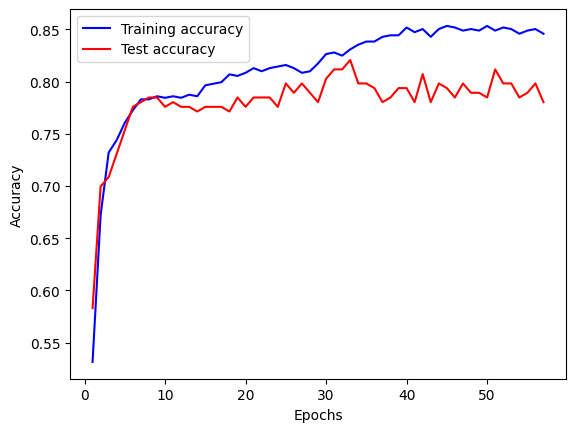

In [135]:
plot_training(hist.history)

# Run on test data and submit to Kaggle

In [136]:
#scale and split data
X_real_test_Id= pd.read_csv('input/test.csv', usecols=["PassengerId"])

if scale==False:
     X_real_test = df_test
     print('Used NOT scaled data!')

elif scale==True:
    X_real_test = X_test_np_scaled
    print('Used scaled data!!')

Used scaled data!!


In [137]:
#fit the data on training data with the best parameters from the hyperparametr tunning

m=model

#predict data from the test data
test_pred = m.predict(X_real_test)

#craeate dataframe for submission
df_newsub = X_real_test_Id.copy()
df_newsub['Survived'] = [1 if x >= 0.5 else 0 for x in test_pred]



14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step


In [138]:
#write data to sumbmission csv
df_newsub.to_csv('output/results.csv', index = False)

# Export model using Joblib

In [141]:
# Save model
joblib.dump(model, filename='output/model.pkl')

['output/model.pkl']